# Final Project: Prey Predator - The invasion 
## Author: Dor Cohen
## Instractor: Dr. Yoav Ram

### **Background**
In class we discussed the simple prey predator model summrized by the lotka-volterra equations which allowed us to  

In this project we will discuss a more complicated scenario where there are 2 populations of predators differnt in their hunting rate. In the begining of this scenrio there is a big population of predator $y_1$ and a small population of $y_2$ but $h_1<h_2$.

In nature scenrio like this happens when there are mutaion which make the hunting rate better or if a invasive species appears.

In [1]:
from functools import partial

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import scipy
from scipy.integrate import solve_bvp, solve_ivp, odeint
from ipywidgets import interact

The equations are: 

$\frac{dx}{dt} = bx - (h_1y_1+h_2y_2)x$

$\frac{dy_1}{dt} = \epsilon_1h_1xy_1 - d_1y_1$

$\frac{dy_2}{dt} = \epsilon_2h_2xy_2 -d_2y_2$

Where the parameters are:

x - prey 

b - birth rate of prey

$y_1$ - native predator

$h_1$ - native predator hunting rate

$\epsilon_1$ - native predator "ingestion rate"

$d_1$ - the native predator death rate

$y_2$ - invasive predator

$h_2$ - invasive predator hunting rate

$\epsilon_2$ - invasive predator "ingestion rate"

$d_2$ - the invasive predator death rate


For simplicity I'll assume that the invasive predator has only different hunting rate. The differnet huning rate gives the invasive predator evolutionary advantage  

Therefore, $\epsilon_1=\epsilon_2=\epsilon$ and $d_1=d_2=d$

The equations will be:

$\frac{dx}{dt} = bx - (h_1y_1+h_2y_2)x$

$\frac{dy_1}{dt} = \epsilon h_1xy_1 - dy_1$

$\frac{dy_2}{dt} = \epsilon h_2xy_2 -dy_2$

In [2]:
def dxy1y2dt(t, xy1y2, b, h1, h2, ϵ, d):
    x, y1, y2 = xy1y2
    dx = b * x - (h1*y1+h2*y2)*x
    dy1 = ϵ * h1 * x * y1 - d * y1
    dy2 = ϵ * h2 * x * y2 - d * y2
    return np.array([dx, dy1, dy2])

## Numerical solution with for loop :

In [3]:
# model parameters
b = 1
h1 = 0.005
h2 = 0.006
ϵ = 0.8
d = 0.6

steps = 100000 # number integration steps
xy = np.empty((3, steps)) # population array
xy[:,0] = 50, 100, 5
dt = 0.001 # time step for integration
for t in range(1, steps):
    xy[:, t] = xy[:, t-1] + dxy1y2dt(t, xy[:, t-1], b, h1, h2, ϵ, d) * dt
x = xy[0, :]
y1 = xy[1, :]
y2 = xy[2, :]
t = np.arange(0, dt * steps, dt)

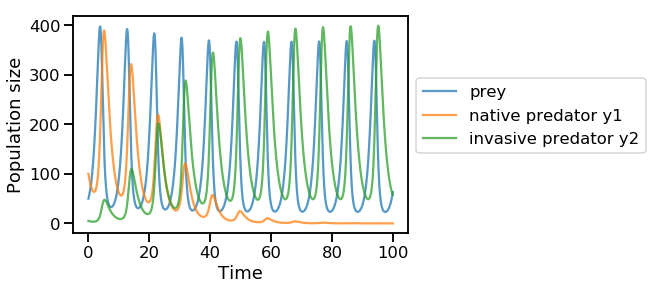

In [4]:
plt.plot(t, x, alpha=0.75, label='prey')
plt.plot(t, y1, alpha=0.75, label='native predator y1')
plt.plot(t,y2, alpha=0.75, label='invasive predator y2')
plt.xlabel('Time')
plt.ylabel('Population size')
# bbox_to_anchor places the legend at specific position, in this case outside the plot
plt.legend(bbox_to_anchor=(1, 0.75));

We can see that the native predator was extincted. This is with just ~16% hunting advantage. 

## Using SciPy

### Let's calculate the Jacobian:

$$
J(x, y_1,y_2) = 
\pmatrix{
    \frac{\partial^2 x}{\partial t \partial x} & \frac{\partial^2 x}{\partial t \partial y_1} & \frac{\partial^2 x}{\partial t \partial y_2} \\
    \frac{\partial^2 y_1}{\partial t \partial x} & \frac{\partial^2 y_1}{\partial t \partial y_1} & \frac{\partial^2 y_1}{\partial t \partial y_2} \\
    \frac{\partial^2 y_2}{\partial t \partial x} & \frac{\partial^2 y_2}{\partial t \partial y_1} & \frac{\partial^2 y_2}{\partial t \partial y_2}
} = 
\pmatrix{
    b - h_1 y_1 - h_2y_2 & -h_1 x & -h_2 x \\
    \epsilon h_1 y_1 & \epsilon h_1 x - d & 0 \\
    \epsilon h_2 y_2 & 0 & h_2 x - d
}
$$

In [6]:
def jac(t, xy1y2, b, h1, h2, ϵ, d):
    x, y1, y2 = xy1y2
    return np.array([
        [b - h1 * y1 - h2 * y2, -h1 * x, -h2 * x],
        [ϵ * h1 * y1, ϵ * h1 * x - d, 0],
        [ϵ * h2 * y2, 0, h2 * x - d]
    ])

In [7]:
def solve_plot(x0, y1_0, y2_0 , tmax, b, h1, h2, ϵ, d, title, isPlotting=True):
    t = np.linspace(0, tmax, tmax*10)
    xy1y2_0 = (x0, y1_0, y2_0)
    _dxy1y2dt = partial(dxy1y2dt, b=b, h1=h1, h2 = h2, ϵ=ϵ, d=d)
    _jac = partial(jac, b=b, h1=h1, h2=h2, ϵ=ϵ, d=d)
    sol = solve_ivp(_dxy1y2dt, (t.min(), t.max()), xy1y2_0, t_eval=t, method='BDF', jac=_jac)
    if isPlotting:
        plt.plot(sol.t, sol.y.T)
        plt.xlabel('Time')
        plt.ylabel('Population size')
        plt.title(title)
    return sol.t,sol.y

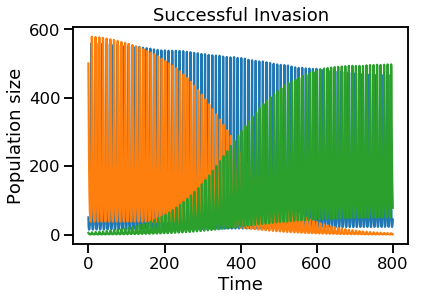

In [8]:
h2 = 0.0051 # h1 = 0.005
t, xy = solve_plot(50, 500, 5, 800, b, h1, h2, ϵ, d,"Successful Invasion")

We can see that even with ~2% hunting rate improvement the invasive is sucessful

## Stability Analysis 

We saw in class the NE of the system without the invasive predator. We got that: 

$$
x^* = \frac{d}{\epsilon h_1} \\
y_1^* = \frac{b}{h_1}
$$

Unlike the previous scnerio, the Nash equilibrium is not the right way to analyse the stability of invasion. The right framework is that of **EVOLUTIONARY GENETIC STABILITY.**

The point is to find the steady state without y2, which we already found in class and saw above. Then find the linear approximation (i.e. Taylor expansion) of $\frac{dy_2}{dt}$ around $(x^*, y_1^*,0)$.

$f(x,y_1,y_2)=\frac{dy_2}{dt} = \Sigma_{k=0}^{k=\infty}\,\Sigma_{l=0}^{l=\infty}\,\Sigma_{j=0}^{j=\infty}\,\frac{\partial^k\partial^l\partial^j f}{\partial^k x\partial^l y_1\partial^j y_2}(x^*,y_1^*,0)\,{(x-x^*)}^k{(y_1-y_1^*)}^l{y_2}^j$

We want only the linear approximation and we get:

$\frac{dy_2}{dt} = f(x^*,y_1^*,0) + \frac{\partial f}{\partial x}(x^*,y_1^*,0)\,(x-x^*) + \frac{\partial f}{\partial y_1}(x^*,y_1^*,0)\,(y_1-y_1^*) + \frac{\partial f}{\partial y_2}(x^*,y_1^*,0)\,y_2 + R_1(x,y_1,y_2) = (\frac{h_2}{h_1}d - d)y_2 + R_1(x,y_1,y_2) $ 

Where $R_1(x,y_1,y_2)$ and $f=\frac{dy_2}{dt}$ is the remindar of Taylor series. 

If the derivative of this linear approximation with respect to $y+2$ is negative, then $(x^*, y_1^*, 0)$ is stable to perturbations in $y_2$, that is, increasing $y_2$ from 0 to ε  will lead to the system returning to $(x^*, y_1^*, 0)$. 

Let's look on the derivative of the linear aproximation with respect to $y_2$

$\frac{h_2}{h_1}d - d$

Therefore, $(x^*, y_1^*, 0)$ is stable iff $h1>h2$ and unstable otherwise!

**If the invasive predator is better hunter and it "joins" stable system the invasion will be successfull**  

Before I'll contine to the next part, let's see an example where $h_2<h_1$:

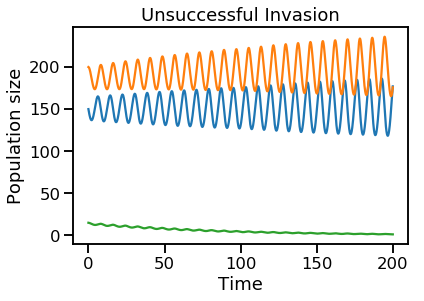

In [8]:
xstar = d/(ϵ*h1)
ystar = b/h1
t, xy =solve_plot(xstar, ystar, 15, 200, b, 0.005, 0.0049, ϵ, d, "Unsuccessful Invasion")

## Change in 2 parameters
What if the hunting rate increase but the death rate d also increase - for example, predator $y_2$ starts to hunt sick prey which $y_1$ avoid because of the danger in eating sick prey. 
Now we have $h_1,\,h_2$ and $d_1,\,d_2$ where $h_2>h_1$ and $d_2>d_1$. 
If we go back to our stability analysis we will get NE of the system without the invasive predator

$$
x^* = \frac{d_1}{\epsilon h_1} \\
y_1^* = \frac{b}{h_1}
$$

The linear approximation of $\frac{dy_2}{dt}$ around $(x^*, y_1^*,0)$ will be:
$(\frac{h_2}{h_1}d_1 - d_2)*y_2$.
The system will be stable only when:
$\frac{h_2}{h_1}d_1 - d_2<0$
And we get: $\frac{d_2}{d_1}>\frac{h_2}{h_1}$
Therefore, if the ratio between the death rates is biger than the ratio between the huntting rate the system will be stalbe. 

In simple words the increase in percentage in the death rate should be higher than the increase in percentage in for invasion to fail.

A similar analysis can be done for $\epsilon$


## Why doesn't evolution "creates" the "prefect hunter" ?

I think we know the answer for this question from Hw4 - where we saw that high hunting rate value has high extinction probability (because of the extinction of the prey).  
We saw that in our model the group of predator with the quality of being better hunter will dominate after some time (untill the extinction of the other group. Now we will see how consecutive improvment in the hunting skills will decrease the population size. 
Let's assume that every 10 days the hunting rate of $y_2$ is improved by 2%.
I'll implement it using loops for **simplicity**, it is just for this example. 

Text(0.5,1,'Consecutive Invasions')

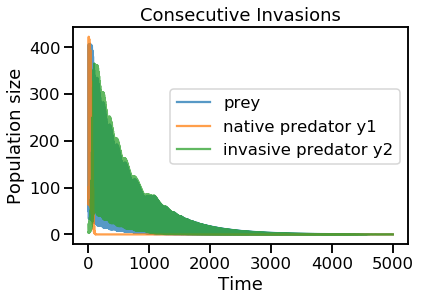

In [10]:
h2 = h1
steps = 5000000 # number integration steps
xy = np.empty((3, steps)) # population array
xy[:,0] = 50, 100, 5
dt = 0.001 # time step for integration
for t in range(1, steps):
    if (t-1)%10000==0:
        h2 = h2*(1.02)
    xy[:, t] = xy[:, t-1] + dxy1y2dt(t, xy[:, t-1], b, h1, h2, ϵ, d) * dt
x = xy[0, :]
y1 = xy[1, :]
y2 = xy[2, :]
t = np.arange(0, dt * steps, dt)

plt.plot(t, x, alpha=0.75, label='prey')
plt.plot(t, y1, alpha=0.75, label='native predator y1')
plt.plot(t,y2, alpha=0.75, label='invasive predator y2')
plt.xlabel('Time')
plt.ylabel('Population size')
# bbox_to_anchor places the legend at specific position, in this case outside the plot
plt.legend(bbox_to_anchor=(1, 0.75));
plt.title("Consecutive Invasions")
# The population size decrease futher and futher, after ~300 genrations, there is extinction

## Adding Stochastic effects

**In this section I'll calculate the extinction probability of the native predators $y_1$ in the first 50 days (assuming `t` is in days) and plot it as a function of $\delta$ where $h_2 = (1+\delta)*h_1$**. I'll assume that the invasive predator has better hunting skills.

First, let look on the reaction table:


\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } a_i \\
x \rightarrow x+1,\;\;\;\; & b*x \\
x \rightarrow x-1, \;\;\;\; &(1-\epsilon)*(h_1*x*y_1 + h_2*x*y_2)\\
y_1 \rightarrow y_1+1, \;\;\;\; & ϵ * h_1 * x * y_1 \\
y_1 \rightarrow y_1-1, \;\;\;\; & d * y_1 \\
y_2 \rightarrow y_2+1, \;\;\;\; & ϵ * h_2 * x * y_2 \\
y_2 \rightarrow y_2-1, \;\;\;\; & d * y_2.
\end{array}
\end{align}

In [9]:
## Import
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.stats
from scipy.integrate import solve_ivp
import seaborn as sns
sns.set_context('notebook')
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)

# setting the values again
b = 1
h1 = 0.005
h2 = 0.0055
ϵ = 0.8
d = 0.6
xstar = d/(ϵ*h1)
ystar = b/h1

In [10]:
@numba.jit # 2-fold faster
def get_rates(x, y1, y2, b, h1, h2, ϵ, d):
    return np.array([
        b*x,     # prey birth rate
        (h1*x*y1+h2*x*y2),      # prey being hunted rate
        ϵ*h1*x*y1, # native predator converting prey mass to predator mass rate
        d*y1,  # native predator death rate
        ϵ*h2*x*y2, # invasive predator converting prey mass to predator mass rate
        d*y2 #invasive predator death rate
    ])

@numba.jit # 2-fold faster
def draw_time(rates):
    total_rate = rates.sum()
    total_rate = max(total_rate,10**(-1)) # don't want to divide by zero
    return np.random.exponential(1/total_rate)

def draw_reaction(rates):
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

updates = np.array([
    [1, 0, 0],  # prey birth
    [-1, 0, 0], # prey being hunted
    [-1, 1, 0],  # native predator converting prey mass to predator mass, prey dies
    [0, -1 ,0], # native predator death
    [-1, 0, 1],  # invasive predator converting prey mass to predator mass, prey dies
    [0, 0, -1]  # invasive predator death
])


In [11]:
def gillespie_step(x, y1, y2, b, h1, h2, ϵ, d):
    rates = get_rates(x, y1, y2, b, h1, h2, ϵ, d)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy1, Δy2 = updates[ri]
    return Δt, Δx, Δy1, Δy2

In [12]:
%%time
def gillespie_ssa(b, h1, h2, ϵ, d, t0=0, x0=0, y10=0, y20=0, t_steps=1000, tmax=50):
    times = np.linspace(t0, tmax, t_steps) # recording times: time points in which to record the state
    states = np.zeros((updates.shape[1], t_steps), dtype=int) # recorded states
    
    # init
    t = t0
    x, y1, y2 = x0, y10, y20
    Δx, Δy1, Δy2 = 0, 0, 0
    # loop over recording times
    for i, next_t in enumerate(times):
        # simulate until next recording time
        if y1<1 and y2<1:
            states[0,i:] = x
            break
        while t < next_t:
            if y1<1 and y2<1:
                break;
            Δt, Δx, Δy1, Δy2 = gillespie_step(x, y1, y2, b, h1, h2, ϵ, d)
            t, x, y1, y2 = t+Δt, x+Δx, y1+Δy1, y2+Δy2
            
        # record the previous state for the time point we just passed
        states[:, i] = x - Δx, y1 - Δy1, y2 - Δy2
    # return array equivalent to [[times, prey, predator] for t in times]
    return np.concatenate((times.reshape(1, -1), states), axis=0)

t, x, y1, y2 = gillespie_ssa(b, h1, h2, ϵ, d, t0=0, x0=50, y10=100, y20=5, t_steps=1000, tmax=50)

CPU times: user 2.86 s, sys: 445 ms, total: 3.31 s
Wall time: 3.33 s


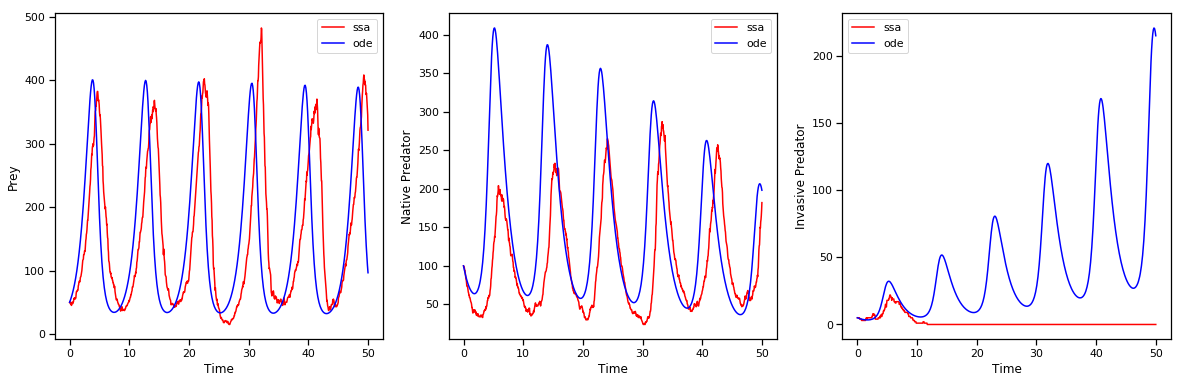

In [13]:
T, XY = solve_plot(50,100, 5, 50, b, h1, h2, ϵ, d, "", False)


fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(t, x, color = 'red', label = 'ssa')
axes[0].plot(T,XY[0,:], color = 'blue', label = 'ode')
axes[0].set(xlabel='Time', ylabel='Prey')
axes[0].legend()
axes[1].plot(t, y1, color = 'red', label = 'ssa')
axes[1].plot(T,XY[1,:], color = 'blue', label = 'ode')
axes[1].set(xlabel='Time', ylabel='Native Predator');
axes[1].legend();
axes[2].plot(t, y2, color = 'red', label = 'ssa')
axes[2].plot(T,XY[2,:], color = 'blue', label = 'ode')
axes[2].set(xlabel='Time', ylabel='Invasive Predator');
axes[2].legend();

**Now will calculate the native predator extinction probability as function of $\delta$**

In [14]:
reps = 5000

from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

f = gillespie_ssa
kwargs = dict(b=b, h1=h1, h2=h2, ϵ=ϵ, d=d, t0=0, x0=xstar, y10=ystar, y20=5, t_steps=1000, tmax=50)
cpus = cpu_count()


In [ ]:
%%time
h2_range = h1*(1+np.logspace(-2,0.5,num=15))
h2_range = np.concatenate((h1*np.ones(1), h2_range), axis=None)
i = 0
invasivePredatorSurviveProb = np.zeros(h2_range.size)
nativePredatorSurviveProb = np.zeros(h2_range.size)
onlyInvasive = np.zeros(h2_range.size)
for h2 in h2_range:
    print("Running {} simulations on {} CPUs for h2 = {}".format(reps, cpus,h2))
    kwargs = dict(b=b, h1=h1, h2=h2, ϵ=ϵ, d=d, t0=0, x0=xstar, y10=ystar, y20=5, t_steps=1000, tmax=50)
    with ProcessPoolExecutor(cpus) as executor:
        futures = [executor.submit(f, **kwargs) for _ in range(reps)]

    results = []
    for fut in as_completed(futures):
        if fut.exception():
            warnings.warn(str(fut.exception()))
        else:
            results.append(fut.result())
    results = np.array(results)
    invasivePredator = results[:,3].min(axis=1)
    nativePredator = results[:,2].min(axis=1)
    invasivePredatorSurviveProb[i] =1- np.count_nonzero(invasivePredator==0)/reps
    nativePredatorSurviveProb[i] =1- np.count_nonzero(nativePredator==0)/reps
    onlyInvasive[i] = np.count_nonzero((invasivePredator>0)*(nativePredator==0))/reps
    i=i+1



Running 5000 simulations on 2 CPUs for h2 = 0.005


In [ ]:
f, ax = plt.subplots(1)
ax.plot((h2_range-h1)/h1, 100*invasivePredatorSurviveProb)
ax.set_xlabel("delta")
ax.set_ylabel("Invasive Predator Survive Probability");
ax.set_title("Invasive predator Survive Probability Againt Delta")
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
plt.show(f)

The detremnstic model tells us that for every $h_2>h_1$ the invasion will be successful. The reality is neature is more complicated. In nature we have stochastics behaviour thus it is likely for a small invasion to fail even if it has huting rate advantage. In the graph above you can see that the maximum survive probability is around 30% and it takes relativly big hunting advantage. 
In addition, you can see that if the adavantage is too high then the extiction probability becomes higher, because the invasive predator is too good (as we have seen in HW4). 

In [ ]:
## To Sum Up:
My thought about the results and the project:
1. In our stochastic model - a small group of invasive has small probability to become the dominate specie. Even though it still has up to 6 times more chance to survive without the hunting rate.
1. In our model the 2 predator group reproduction is asexual reproduction, it will be intrestring to see what happens if we will allow sexual reproduction between the groups.